In [1]:
#!/usr/bin/python

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import time
from reservoir import Reservoir
import data_utils

%load_ext autoreload
%autoreload 2
%aimport reservoir
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Input data
T_3D = np.load("2D_convection_datasets/x_y_temperature_deltaT_2.npy")[1:, :, :] # skipping the boundary layer
x_dim, y_dim, sequence_length = T_3D.shape
# T_2D_concat = np.transpose(T_3D[1:, :, :], axes=(0, 2, 1))
# T_2D_concat = np.tanh((T_2D_concat - np.mean(T_2D_concat))/np.std(T_2D_concat))
T_2D_concat = T_3D.reshape((x_dim*y_dim, sequence_length)).T.reshape((1, sequence_length, x_dim*y_dim))
T_2D_concat = np.tanh((T_2D_concat - np.mean(T_2D_concat))/np.std(T_2D_concat))
# plt.figure(0,figsize=(8, 2))
# im=plt.pcolormesh(T_2D_concat[0].T, cmap='gist_heat')
# plt.colorbar(im)
# plt.show

n_sequence, sequence_length, spatial_points = T_2D_concat.shape

b = Reservoir(n_res=2000, res_scale=1, res_encoding='phase', res_enc_param=1.5*np.pi,
              input_scale=1, input_encoding='phase',
              random_projection='simulation', weights_type='complex gaussian',
              activation_fun='intensity', activation_param=10,
              parallel_runs=1,  bias_scale=0, leak_rate=0.1,
              pred_horizon=2, rec_pred_steps=1, forget = 100,
              train_method='ridge', train_param=1e2, verbose=1
             )

# Algorithm training
b.fit(T_2D_concat);

Reservoir Computing algorithm - Training phase:

Initialization complete. 		Elapsed time: 1.1557555198669434 s
100%|██████████| 1201/1201 [00:09<00:00, 123.00it/s]
Reservoir iterations complete. 		Elapsed time: 9.804123878479004 s


In [ ]:
# testing data
T_3D = np.load("2D_convection_datasets/x_y_temperature_deltaT_8.npy")[1:, :, :] # skipping the boundary layer
# T_2D_concat = np.transpose(T_3D[:, :, :], axes=(0, 2, 1))[1:]
# T_2D_concat = np.tanh((T_2D_concat - np.mean(T_2D_concat))/np.std(T_2D_concat))

T_2D_concat = T_3D.reshape((x_dim*y_dim, sequence_length)).T.reshape((1, sequence_length, x_dim*y_dim))
T_2D_concat = np.tanh((T_2D_concat - np.mean(T_2D_concat))/np.std(T_2D_concat))
# Algorithm testing
pred_output, valid_score = b.predict_and_score(T_2D_concat, detailed_score=True)

<function matplotlib.pyplot.show(*args, **kw)>

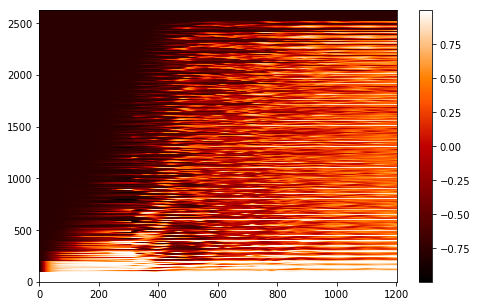

In [4]:
plt.figure(0,figsize=(8, 5))
im=plt.pcolormesh(T_2D_concat[0].T, cmap='gist_heat')
plt.colorbar(im)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

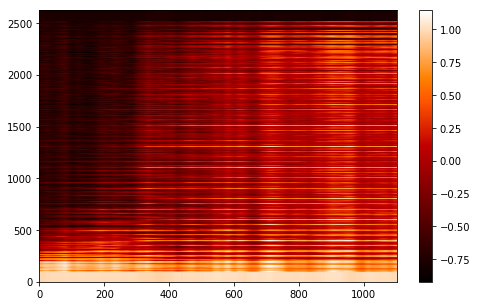

In [5]:
plt.figure(0,figsize=(8, 5))
im=plt.pcolormesh(pred_output[:, :spatial_points].T, cmap='gist_heat')
plt.colorbar(im)
plt.show

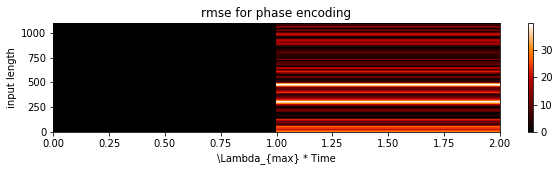

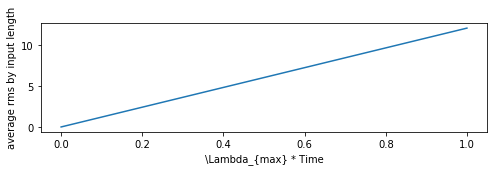

In [29]:
# prediction RMSE
total_pred = b.pred_horizon*b.rec_pred_steps
true_data = T_2D_concat[:, b.forget:, :]
true_data_std = np.std(true_data) # think about better normalization
true_data_norm = data_utils.roll_and_concat(true_data, roll_num=b.pred_horizon)[0]/true_data_std
pred_output_norm = pred_output/true_data_std
length_input = pred_output.shape[0] - total_pred
rmse = np.zeros((length_input, total_pred))
for n_input in range(1, length_input):
    for n_pred in range(1, total_pred):
        d1 = pred_output_norm[n_input, :].reshape(-1, spatial_points)[0:n_pred,:]
        d2 = true_data_norm[n_input:n_input+n_pred, 0:spatial_points]
        
        rmse[n_input, n_pred] = np.sqrt(1./(n_pred*(spatial_points+1))*np.sum((d1.flatten() - d2.flatten())**2))

plt.figure(1,figsize=(10,2))
plt.title('rmse for phase encoding')
plt.ylabel('input length')
plt.xlabel('\Lambda_{max} * Time')
im=plt.pcolormesh(rmse[:,:], cmap='gist_heat')
plt.colorbar(im)
plt.show;

plt.figure(2,figsize=(8,2))
plt.ylabel('average rms by input length')
plt.xlabel('\Lambda_{max} * Time')
plt.plot(np.mean(rmse[:,:], axis=0))
plt.show;
# np.save('SLM_timesteps_20000.npy', np.sum(rmse[:,1:], axis=0)/length_input)

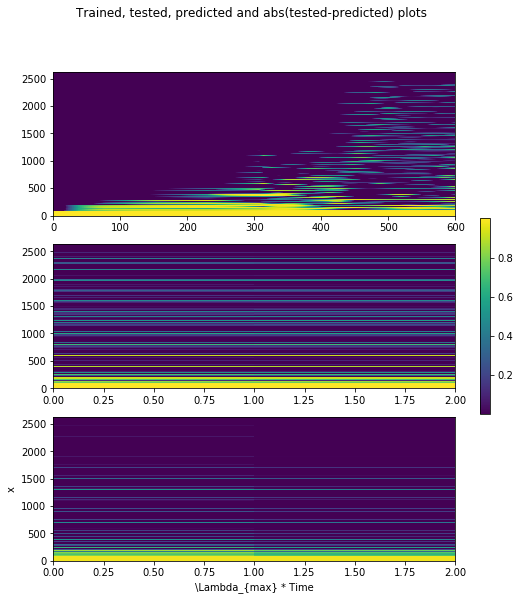

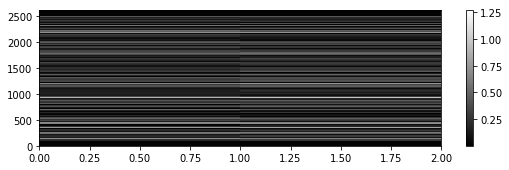

In [6]:
total_pred = b.pred_horizon*b.rec_pred_steps
n_input = 500 #round(pred_output.shape[0]/2-300)
input_data = T_2D_concat[0, :n_input+b.forget, :]
prediction = pred_output[n_input, :].reshape(-1, spatial_points)
targetted_data = T_2D_concat[0, n_input+b.forget:n_input+b.forget+total_pred, :]

vmax = np.amax(abs(np.concatenate((targetted_data, input_data, prediction))))
vmin = np.min(abs(np.concatenate((targetted_data, input_data, prediction))))

# plot training data
fig, axs = plt.subplots(3, 1, sharex=False, figsize=(9,9))
plt.suptitle('Trained, tested, predicted and abs(tested-predicted) plots                       ')
plt.ylabel('x')
plt.xlabel('\Lambda_{max} * Time')
datum = [input_data, targetted_data, prediction, np.abs(targetted_data-prediction)]
for i in range(3):
    im=axs[i].pcolormesh(datum[i].T, cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.4)

plt.figure(3,figsize=(9,2.5))
im=plt.pcolormesh(datum[3].T, cmap='gray')
plt.colorbar(im)
# # plt.savefig('DND_input_data.png')

<function matplotlib.pyplot.show(*args, **kw)>

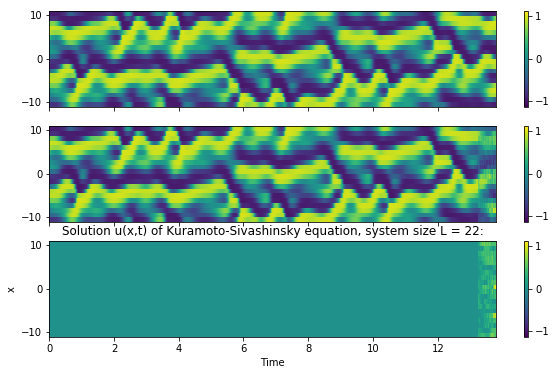

In [14]:
n_input = 1250 #round(pred_output.shape[0]/2-300)
prediction = np.zeros((total_pred, spatial_points + 1))
for i in range(total_pred):
    prediction[i, :] = pred_output[n_input, i*(spatial_points+1):(i+1)*(spatial_points + 1)]
all_data = np.concatenate((y_target[0:n_input, 0:spatial_points+1], prediction*(1/np.amax(prediction))))

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10,6))
data_1 = y_target[0:n_input+total_pred, 0:spatial_points+1].T
data_2 = all_data.T
data_3 = y_target[0:n_input+total_pred, 0:spatial_points+1].T-all_data.T
time = tt[0:n_input+total_pred]*lyap_exp
vmax = max(abs(np.concatenate((data_1,data_2,data_3)).flatten()))
vmin = -vmax
plt.title('Solution u(x,t) of Kuramoto-Sivashinsky equation, system size L = 22:')
plt.ylabel('x')
plt.xlabel('Time')
im=axs[0].pcolormesh(time, xx, y_target[0:n_input+total_pred, 0:spatial_points+1].T, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[0])

im=axs[1].pcolormesh(time, xx, all_data.T, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[1])

im=axs[2].pcolormesh(time, xx, np.abs(y_target[0:n_input+total_pred, 0:spatial_points+1].T-all_data.T), cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[2])
plt.show